In [32]:
"""
https://pytorch.org/docs/stable/nn.html
"""
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn



In [101]:
class Data(Dataset):
    def __init__(self, X, Y):
        """
        Initialize the wine dataset variables.
        :param X: Features of shape [n, num_genes], where n is number of samples.
        :param Y: Labels of shape [n], where n is number of samples.
        
        """
        print("Dataset", X.shape, Y.shape)
        self.X = X
        self.Y = Y


    def __len__(self):
        """
        Returns the number of samples.
        :return: The number of samples.
        """
        return self.X.shape[0]

    def __getitem__(self, index):
        """
        Returns feature and label of the sample at the given index.
        :param index: Index of a sample.
        :return: Feature and label of the sample at the given index.
        """
        return self.X[index], torch.Tensor([self.Y[index]])
    

In [114]:
def get_data_loader(batch_size, dataset_X ='processed_mrna_data.npy', dataset_Y = 'processed_recurrence_data.npy', test_size=0.2):
    """
    Returns train/test dataloaders
    :param dataset: Path dataset 
    :param test_size: Ratio of (test set size / dataset size)
    :return: Dataloaders for training set and test set.
    """
    # Check if the file exists
    
    # Load the dataset
    X = np.load(dataset_X)
    Y = np.load(dataset_Y)

    # Normalize the features
    #X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

    # Convert to float32
    X = X.astype(np.float32)
    Y = Y.astype(np.float32)
    # Split data into training set and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)

    # Build dataset
    dataset_train = Data(X_train, Y_train)
    dataset_test = Data(X_test, Y_test)

    # Build dataloader
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

    return dataloader_train, dataloader_test

In [126]:
class OneLayerNN(nn.Module):

    def __init__(self, input_features=20531):
        """
        Initializes a liner layer.
        :param input_features: The number of features of each sample.
        """
        super().__init__()

        # TODO: Initialize a linear layer. HINT: torch.nn.Linear
        self.layer = torch.nn.Linear(input_features, 1)

    def forward(self, X):
        """
        Applies the linear layer defined in __init__() to input features X.
        :param X: 2D torch tensor of shape [n, 11], where n is batch size.
            Represents features of a batch of data.
        :return: 2D torch tensor of shape [n, 1], where n is batch size.
            Represents prediction of wine quality.
        """

        # TODO: Apply the linear layer defined in __init__() to input features X
        return self.layer(X)

In [116]:
class TwoLayerNN(nn.Module):

    def __init__(self, input_features):
        """
        Initializes model layers.
        :param input_features: The number of features of each sample.
        """
        super().__init__()

        # TODO: Tune the hidden size hyper-parameter
        self.hidden_size = 200

        # TODO: Initialize a linear layer. HINT: torch.nn.Linear
        self.layer1 = torch.nn.Linear(input_features, self.hidden_size)
    
        # TODO: Initialize a sigmoid activation layer. HINT: torch.nn.Sigmoid
        self.activation = torch.nn.ReLU()
        # TODO: Initialize another linear layer
        self.layer2 = torch.nn.Linear(self.hidden_size, 20)
        self.activation = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(self.hidden_size, 1)


        self.model = torch.nn.Sequential(self.layer1, self.activation, self.layer2)
    def forward(self, X):
        """
        Applies the layers defined in __init__() to input features X.
        :param X: 2D torch tensor of shape [n, 11], where n is batch size.
            Represents features of a batch of data.
        :return: 2D torch tensor of shape [n, 1], where n is batch size.
            Represents prediction of wine quality.
        """

        # TODO: Apply the layers defined in __init__() to input features X
        return self.model(X)
        



In [37]:

class CNN(nn.Module):

    def __init__(self, input_channels=20531, class_num=2):
        """
        Initializes model layers.
        :param input_channels: The number of features of each sample.
        :param class_num: The number of categories.
        """
        super().__init__()

        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(input_channels, 16, 3),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 32, 3),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, 3),
            torch.nn.ReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear(256, class_num)
        )

    def forward(self, X):
        """
        Applies the layers defined in __init__() to input features X.
        :param X: 4D torch tensor of shape [n, 1, 8, 8], where n is batch size.
            Represents a batch of 8 * 8 gray scale images.
        :return: 2D torch tensor of shape [n, 10], where n is batch size.
            Represents logits of different categories.
        """

        return self.model(X)



In [128]:
def train(model, dataloader, loss_func, optimizer, num_epoch, correct_num_func=None, print_info=True):
    """
    Trains the model for `num_epoch` epochs.
    :param model: A deep model.
    :param dataloader: Dataloader of the training set. Contains the training data equivalent to ((Xi, Yi)),
        where (Xi, Yi) is a batch of data.
        X: 2D torch tensor for UCI wine and 4D torch tensor for MNIST.
        X: 2D torch tensor for UCI wine and 1D torch tensor for MNIST, containing the corresponding labels
            for each example.
        Refer to the Data Format section in the handout for more information.
    :param loss_func: An MSE loss function for UCI wine and a cross entropy loss for MNIST.
    :param optimizer: An optimizer instance from torch.optim.
    :param num_epoch: The number of epochs we train our network.
    :param correct_num_func: A function to calculate how many samples are correctly classified.
        You need to implement correct_predict_num() below.
        To train the CNN model, we also want to calculate the classification accuracy in addition to loss.
    :param print_info: If True, print the average loss (and accuracy, if applicable) after each epoch.
    :return:
        epoch_average_losses: A list of average loss after each epoch.
            Note: different from HW10, we will return average losses instead of total losses.
        epoch_accuracies: A list of accuracy values after each epoch. This is applicable when training on MNIST.
    """

    average_loss = []
    accuracys = []
    
    model.train()
    for epoch in range(num_epoch):

        # Initializing variables

        # Sum of losses in an epoch. Will be used to calculate average loss.
        # The reason we are using (epoch_loss_sum / #samples in each batch) to calculate the
        # average loss is that the number of samples in the last batch may be fewer than your batch_size.
        epoch_loss_sum = 0

        # Sum of the number of correct predictions. Will be used to calculate average accuracy for CNN.
        epoch_correct_num = 0

        # TODO: Iterate through batches. HINT: for X, Y in dataloader:
        for X, Y in dataloader:
            # TODO: Run a forward pass and get model output
            output = model.forward(X)
            # TODO: Set all gradients to zero by calling optimizer.zero_grad()
            optimizer.zero_grad()
            # TODO: Calculate loss of this batch
            loss = loss_func(output, Y)

            # TODO: Run a backward pass by calling loss.backward(),
            #  where loss is the output of the loss function.

            loss.backward()
            # TODO: Update parameters by calling optimizer.step()
            optimizer.step()
            # TODO: Increase epoch_loss_sum by (loss * #samples in the current batch)
            #  Use loss.item() to get the python scalar of loss value because the output of
            #   loss function also contains gradient information, which takes a lot of memory.
            #  Use X.shape[0] to get the number of samples in the current batch.
            epoch_loss_sum += loss.item() * X.shape[0]
            
            # TODO: Calculate the number of correct predictions for CNN on MNIST
            num_correct = correct_predict_num(output, Y)

            # TODO: When correct_num_func is not None,
            #  increase epoch_correct_num by #correct predictions in the current batch
            if correct_num_func != None:
                epoch_correct_num += num_correct

        # TODO: Append the average loss of the current epoch to your list.
        #  You can get the number of training samples by len(dataloader.dataset)
        average_loss.append(epoch_loss_sum / len(dataloader.dataset))

        # TODO: When correct_num_func is not None,
        #  calculate average accuracy for CNN on MNIST if correct_num_func:
        #  Append the average accuracy of the current epoch to your list.
        #  You can get the number of training samples by len(dataloader.dataset)
        if correct_num_func != None:
            accuracys.append(epoch_correct_num / len(dataloader.dataset))

        # Print the loss after every epoch. Print accuracies if specified
        if print_info:
            print('Epoch: {} | Loss: {:.4f} '.format(epoch, epoch_loss_sum / len(dataloader.dataset)), end="")
            if correct_num_func:
                print('Accuracy: {:.4f}%'.format(epoch_correct_num / len(dataloader.dataset) * 100), end="")
            print()

    # TODO: When correct_num_func is None, only return a list of average losses.
    #  When correct_num_func is not None, return a list of average losses and a list of accuracies.
    if correct_num_func == None:
        return average_loss
    else:
        return average_loss, accuracys

In [39]:
def test(model, dataloader, loss_func, correct_num_func=None):
    """
    Tests the model.
    :param model: A deep model.
    :param dataloader: Dataloader of the testing set. Contains the testing data equivalent to ((Xi, Yi)),
        where (Xi, Yi) is a batch of data.
        X: 2D torch tensor for UCI wine and 4D torch tensor for MNIST.
        X: 2D torch tensor for UCI wine and 1D torch tensor for MNIST, containing the corresponding labels
            for each example.
        Refer to the Data Format section in the handout for more information.
    :param loss_func: An MSE loss function for UCI wine and a cross entropy loss for MNIST.
    :param correct_num_func: A function to calculate how many samples are correctly classified.
        You need to implement correct_predict_num() below.
        To test the CNN model, we also want to calculate the classification accuracy in addition to loss.
    :return:
        Average loss.
        Average accuracy. This is applicable when testing on MNIST.
    """
    """
    :param dataloader: Contains the training data equivalent to ((X, Y))
        :param X: 2D Numpy array where each row contains an example
        :param Y: 1D Numpy array containing the corresponding values for each example
    :param loss_func: An MSE loss function from the Pytorch Library
    :return: epoch loss and accuracies to be graphed
    """

    # TODO: Initalizing variables
        # Initialize sum of losses in an epoch. Will be used to calculate average loss.
        # Initialize sum of the number of correct predictions. Will be used to calculate average accuracy for CNN.
    sum_loss = 0
    sum_correct = 0
    # TODO: Tell the model we are in the testing phase. HINT: model.eval()
    model.eval()
    # TODO: During testing, we don't need to calculate gradients. HINT: use 'with torch.no_grad():'
    with torch.no_grad():
        # TODO: Iterate through batches.
        for X, Y in dataloader:
            # TODO: Run a forward pass and get model output
            output = model.forward(X)
            # TODO: Calculate loss of this batch
            loss = loss_func(output, Y)
            # TODO: Increase loss sum by (loss * #samples in the current batch)
            #  Use loss.item() to get the python scalar of loss value.
            #  Use X.shape[0] to get the number of samples in the current batch.
            sum_loss += loss.item() * X.shape[0]
            # TODO: When correct_num_func is not None, calculate the number of correct predictions for CNN on MNIST
            #  Increase the total number of correct predictions by #correct predictions in the current batch
            if correct_num_func != None:
                sum_correct += correct_predict_num(output, Y) 
    # TODO: When correct_num_func is None, return average loss.
    #  When correct_num_func is not None, return average loss and accuracy.
    if correct_num_func == None:
        return sum_loss / len(dataloader.dataset)
    else:
        return sum_loss / len(dataloader.dataset), sum_correct / len(dataloader.dataset)

In [40]:
def visualize_loss(losses):
    """
    Uses Matplotlib to visualize loss per batch.
    :return: None
    """
    x = np.arange(1, len(losses) + 1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.title('Training Loss per Epoch')
    plt.plot(x, losses)
    plt.show()



In [129]:
def correct_predict_num(logit, target):
    """
    Returns the number of correct predictions.
    :param logit: 2D torch tensor of shape [n, class_num], where
        n is the number of samples, and class_num is the number of classes (10 for MNIST).
        Represents the output of CNN model.
    :param target: 1D torch tensor of shape [n],  where n is the number of samples.
        Represents the ground truth categories of images.
    :return: A python scalar. The number of correct predictions.
    """
    # TODO: Calculate the number of correct predictions.
    # HINT: torch.sum, torch.argmax
    # You may need .long() to convert a torch tensor to LongTensor.
    # Use .item() to convert a torch tensor of size 1 to python scalar.
    return torch.sum(torch.argmax(logit, dim=1) == target).item()
    

In [131]:
def test_one_layer(test_size=0.2):
    """
    Tests OneLayerNN
    :param test_size: The ratio of test set
    """

    batch_size = 64  # batch size
    num_epoch = 25  # number of training epochs
    learning_rate = 0.01  # learning rate

    dataloader_train, dataloader_test = get_data_loader(batch_size=batch_size, test_size=test_size)

    model = OneLayerNN(input_features=20531)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    loss_func = torch.nn.BCEWithLogitsLoss()

    losses = train(model, dataloader_train, loss_func, optimizer, num_epoch)

    loss_train = test(model, dataloader_train, loss_func, correct_num_func=correct_predict_num)
    loss_test = test(model, dataloader_test, loss_func, correct_num_func=correct_predict_num)
    print('Average Training Loss:', loss_train)
    print('Average Testing Loss:', loss_test)

test_one_layer()

Dataset (426, 20531) (426,)
Dataset (107, 20531) (107,)
Epoch: 0 | Loss: 33330.0113 
Epoch: 1 | Loss: 18609.4583 
Epoch: 2 | Loss: 4295.1870 
Epoch: 3 | Loss: 6719.8838 
Epoch: 4 | Loss: 2912.6306 
Epoch: 5 | Loss: 6609.8569 
Epoch: 6 | Loss: 4738.8068 
Epoch: 7 | Loss: 5951.1153 
Epoch: 8 | Loss: 3808.2294 
Epoch: 9 | Loss: 3345.8788 
Epoch: 10 | Loss: 2306.0512 
Epoch: 11 | Loss: 759.4360 
Epoch: 12 | Loss: 720.9271 
Epoch: 13 | Loss: 502.8049 
Epoch: 14 | Loss: 512.6524 
Epoch: 15 | Loss: 375.8871 
Epoch: 16 | Loss: 2185.8233 
Epoch: 17 | Loss: 1427.1879 
Epoch: 18 | Loss: 568.8564 
Epoch: 19 | Loss: 473.7797 
Epoch: 20 | Loss: 239.9170 
Epoch: 21 | Loss: 242.9856 
Epoch: 22 | Loss: 132.5957 
Epoch: 23 | Loss: 101.7813 
Epoch: 24 | Loss: 153.5537 
Average Training Loss: (189.92119687935556, 53.72300469483568)
Average Testing Loss: (3687.3639931366824, 43.77570093457944)


Dataset (426, 20531) (426,)
Dataset (107, 20531) (107,)
Epoch: 0 | Loss: 6145.0759 
Epoch: 1 | Loss: 275.0334 
Epoch: 2 | Loss: 0.6884 
Epoch: 3 | Loss: 0.6864 
Epoch: 4 | Loss: 0.6842 
Epoch: 5 | Loss: 0.6820 
Epoch: 6 | Loss: 0.6797 
Epoch: 7 | Loss: 0.6773 
Epoch: 8 | Loss: 0.6750 
Epoch: 9 | Loss: 0.6727 
Epoch: 10 | Loss: 0.6705 
Epoch: 11 | Loss: 0.6681 
Epoch: 12 | Loss: 0.6659 
Epoch: 13 | Loss: 0.6636 
Epoch: 14 | Loss: 0.6613 
Epoch: 15 | Loss: 0.6591 
Epoch: 16 | Loss: 0.6568 
Epoch: 17 | Loss: 0.6546 
Epoch: 18 | Loss: 0.6524 
Epoch: 19 | Loss: 0.6502 
Epoch: 20 | Loss: 0.6479 
Epoch: 21 | Loss: 0.6459 
Epoch: 22 | Loss: 0.6437 
Epoch: 23 | Loss: 0.6415 
Epoch: 24 | Loss: 0.6394 


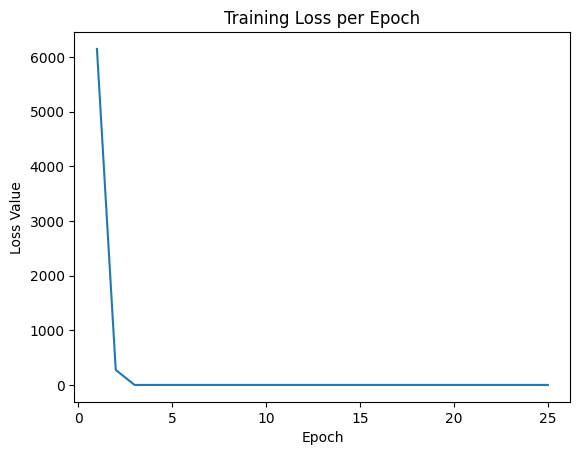

Average Training Loss: 0.6381350078493216
Average Testing Loss: (1.9630104587456891, 45.76635514018692)


(1.9630104587456891, 45.76635514018692)

In [132]:
def test_two_layer(test_size=0.2):
    """
    Tests OneLayerNN
    :param test_size: The ratio of test set
    """

    batch_size = 64  # batch size
    num_epoch = 25  # number of training epochs
    learning_rate = 0.001  # learning rate

    dataloader_train, dataloader_test = get_data_loader(batch_size=batch_size, test_size=test_size)

    model = TwoLayerNN(input_features=20531)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    loss_func = torch.nn.BCEWithLogitsLoss()



    losses = train(model, dataloader_train, loss_func, optimizer, num_epoch)

    visualize_loss(losses)

    loss_train = test(model, dataloader_train, loss_func)
    loss_test = test(model, dataloader_test, loss_func, correct_num_func=correct_predict_num)
    print('Average Training Loss:', loss_train)
    print('Average Testing Loss:', loss_test)
    return loss_test
test_two_layer()

In [145]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor


X = np.load('processed_mrna_data.npy')
Y = np.load('processed_recurrence_data.npy')

X = X.astype(np.float32)
Y = Y.astype(np.float32)


    # Split data into training set and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)


dataset_train = Data(X_train, Y_train)
dataset_test = Data(X_test, Y_test)

dataloader_train = DataLoader(dataset_train, batch_size=64)
dataloader_test = DataLoader(dataset_test, batch_size=64, shuffle=False)


class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(20531, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

Dataset (426, 20531) (426,)
Dataset (107, 20531) (107,)


In [150]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            print(pred)
            print(y)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [151]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(dataloader_train, model, loss_fn, optimizer)
    test_loop(dataloader_test, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 45.624237  [   64/  426]
tensor([[-103.9876],
        [-115.3512],
        [-147.6031],
        [-113.7361],
        [-134.0147],
        [-109.4229],
        [-142.4927],
        [-168.2553],
        [ -85.2652],
        [-143.9309],
        [-146.9219],
        [-195.0726],
        [-195.8924],
        [-137.4620],
        [-144.8747],
        [-103.5915],
        [-140.7576],
        [-134.0744],
        [-126.7491],
        [-144.5330],
        [-112.1868],
        [-110.8455],
        [-148.6163],
        [-134.3767],
        [ -95.8749],
        [-122.6508],
        [ -95.8655],
        [-104.6213],
        [-127.5361],
        [-123.0863],
        [-110.8278],
        [-117.1459],
        [-119.2459],
        [-102.5132],
        [-106.6486],
        [-119.8985],
        [-140.7439],
        [-136.3804],
        [-116.3578],
        [-118.7969],
        [-111.9806],
        [-125.1052],
        [-147.9725],
        [-101.7828],
     